In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib import location
import scienceplots
plt.style.use(["science", "notebook"])

## Data intake

In [154]:
installation_int = 3
ceda = pd.read_pickle(f"Data/Sites/NWP_{installation_int}.pkl")
openmeteo = pd.read_pickle(f"Data/Sites/Reanalysis_{installation_int}.pkl")
pvgis = pd.read_pickle(f'Data/Sites/PVGIS_{installation_int}.pkl')

power = pd.read_pickle(f"Data/Sites/PV_{installation_int}.pkl")
meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation": "downward_surface_SW_flux",
              "diffuse_radiation":"diffuse_surface_SW_flux",
              "direct_normal_irradiance":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)
variates = list(ceda.columns)
rows = int(np.ceil(np.sqrt(len(variates))))

## Historic plot

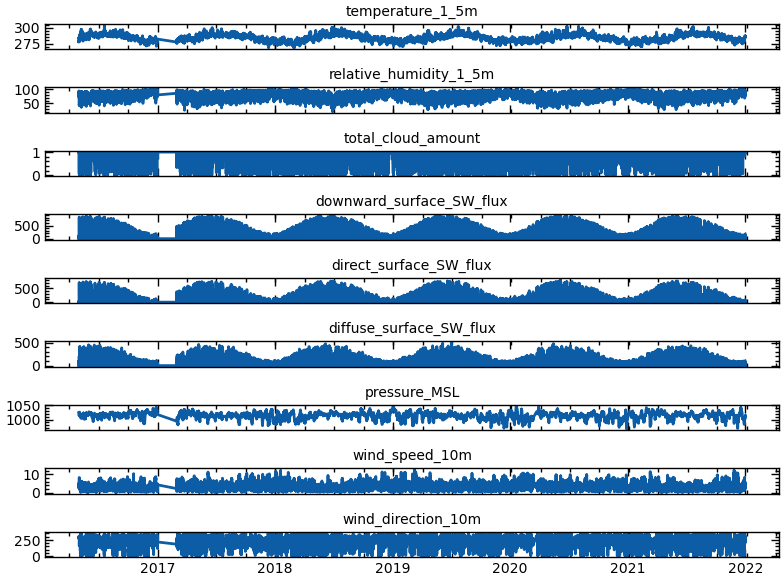

In [155]:
fig, axs = plt.subplots(len(variates), sharex=True)
plt.tight_layout()
for i, var in enumerate(variates):
    axs[i].plot(ceda[var])
    axs[i].set_title(var, fontsize = 10)
    axs[i].tick_params(labelsize=10)
plt.show()


## Histograms

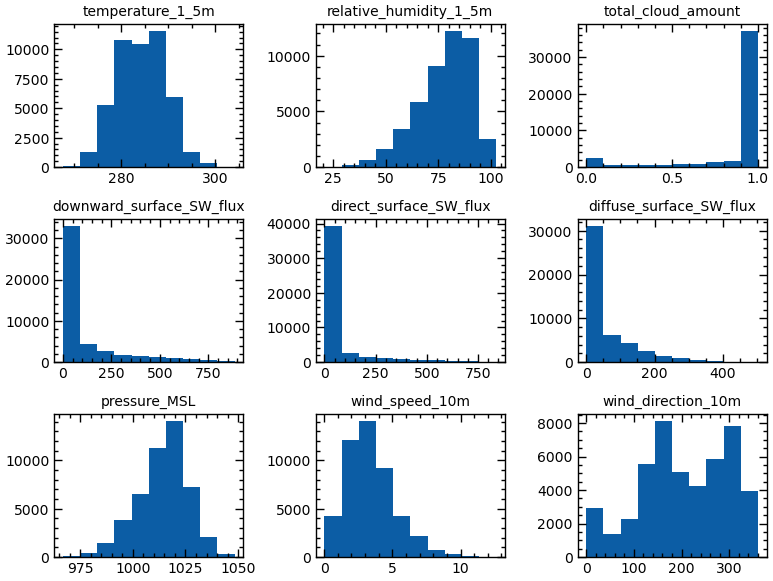

In [156]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## Correlation: CEDA & PROD_NL 

Here add still correlation with transformed variables


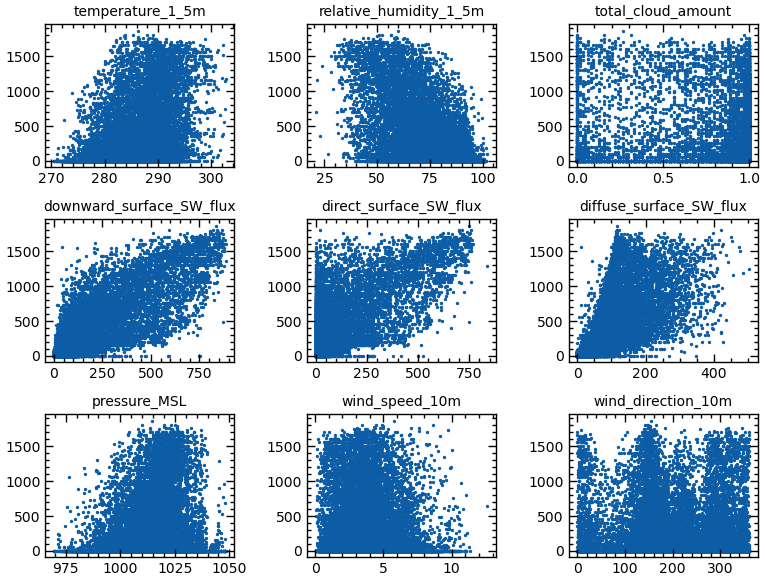

In [157]:
correl = pd.merge(power, ceda, right_index=True, left_index=True)
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter( correl[var],correl ['P'],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

C:\Users\Robbe\AppData\Local\Temp\ipykernel_24224\2571007583.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


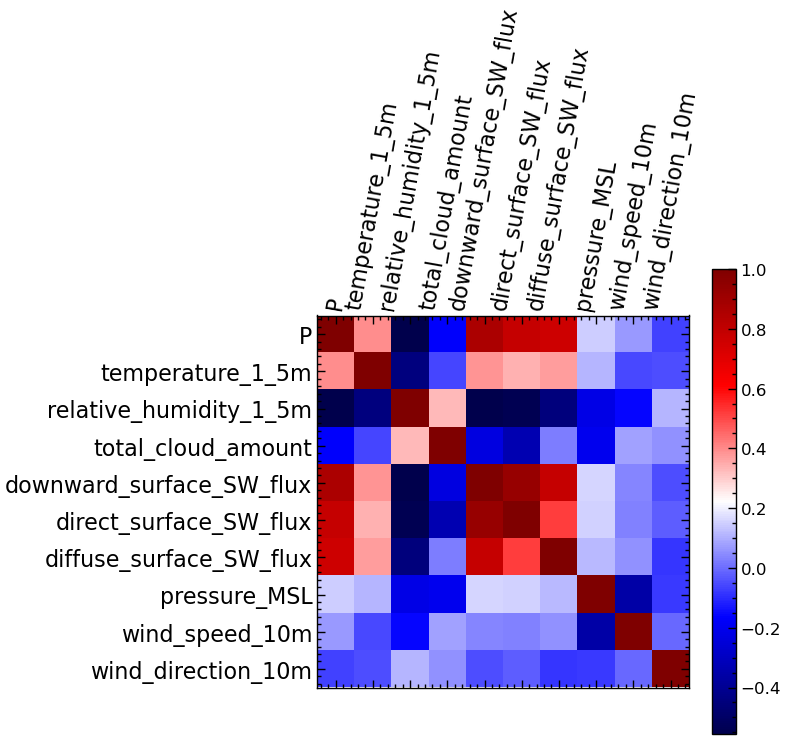

In [158]:
axs = plt.matshow(correl.corr(), cmap='seismic')
plt.xticks(ticks=range(len(variates)+1), labels=list(correl.columns), rotation= 80)
plt.yticks(ticks=range(len(variates)+1), labels = list(correl.columns), rotation= 0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## CEDA VS OPENMETEO

In [159]:
openmeteo = openmeteo.reindex(ceda.index)

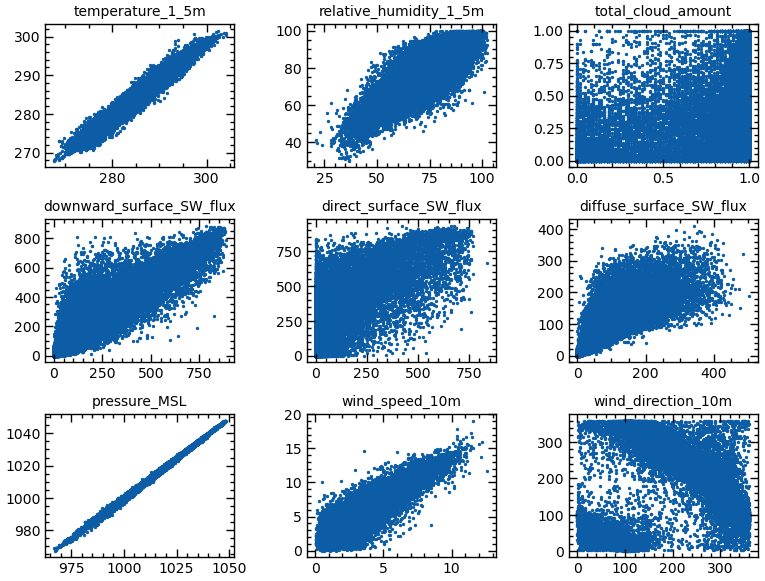

In [160]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter(ceda[var], openmeteo[var],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

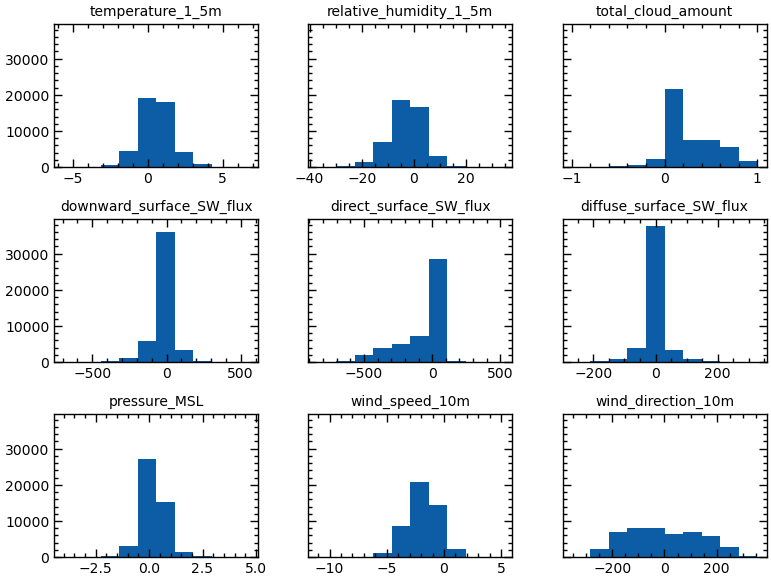

In [161]:
fig, axs = plt.subplots(rows, rows, sharey=True)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var]-openmeteo[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## PROD_NL VS PVGIS

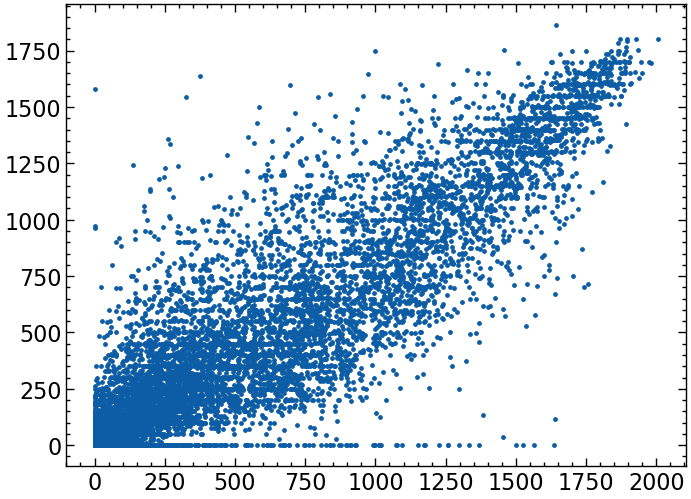

In [162]:
powers= pd.merge(pvgis, power, left_index=True, right_index=True)
plt.scatter(powers['P_x'], powers['P_y'], s=6)

In [163]:
powers.tail(50)

,P_x,P_y
2020-09-28 22:00:00+00:00,0.00,0.00
2020-09-28 23:00:00+00:00,0.00,0.00
2020-09-29 00:00:00+00:00,0.00,0.00
2020-09-29 01:00:00+00:00,0.00,0.00
2020-09-29 02:00:00+00:00,0.00,0.00
2020-09-29 03:00:00+00:00,0.00,0.00
2020-09-29 04:00:00+00:00,0.00,0.00
2020-09-29 05:00:00+00:00,0.00,0.00
2020-09-29 06:00:00+00:00,0.00,0.00
2020-09-29 07:00:00+00:00,62.42,0.00


In [164]:
for k in range(-10,10):
    x = powers['P_x'].shift(k)
    print(f"k={k}",powers['P_y'].corr(x))
    print((power['P']-x).max())

k=-10 -0.306935451805124
1862.92
k=-9 -0.27260040126444646
1862.92
k=-8 -0.21213285604410503
1862.92
k=-7 -0.11905499006397828
1862.92
k=-6 0.010301026308488944
1789.9
k=-5 0.17153141264189803
1722.96
k=-4 0.3564107389436509
1645.96
k=-3 0.5467565772917181
1553.79
k=-2 0.7228913268318534
1538.75
k=-1 0.8583256490258655
1410.6200000000001
k=0 0.9298083017654925
1578.08
k=1 0.8988930652018596
1427.4
k=2 0.7445887156703871
1429.81
k=3 0.5587544063918681
1509.67
k=4 0.3634358939057935
1513.8999999999999
k=5 0.18020326792194646
1654.3400000000001
k=6 0.01922397871582481
1719.04
k=7 -0.10883423678800462
1776.28
k=8 -0.20203488968265912
1803.74
k=9 -0.263029104023735
1862.92


k=-10 -0.3091178289075777
k=-9 -0.2618122404531456
k=-8 -0.18963719557556966
k=-7 -0.08874933824527248
k=-6 0.04250650327939279
k=-5 0.1999197611651992
k=-4 0.3753173691412786
k=-3 0.5541633799570386
k=-2 0.7134807909289064
k=-1 0.8277711305782811
k=0 0.8761950954949377
k=1 0.8493227395298413
k=2 0.7575819123478883
k=3 0.6170142976894833
k=4 0.4482674752950612
k=5 0.271961348422899
k=6 0.10585184018046444
k=7 -0.03920642472167327
k=8 -0.15688025847871243
k=9 -0.24418754453529928


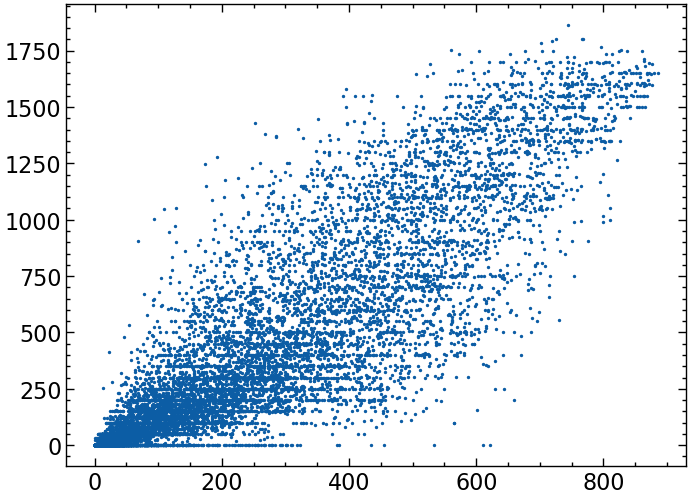

In [165]:
debug = pd.merge(openmeteo, power, left_index=True, right_index=True)
plt.scatter(debug['downward_surface_SW_flux'], debug['P'], s=2)
for k in range(-10,10):
    print(f"k={k}",pvgis.corr(openmeteo['downward_surface_SW_flux'].shift(k)))

## Irradiance forecast errors grouped by solar zenith angle

In [166]:
irradiances_forecast = ceda[['downward_surface_SW_flux', 'direct_surface_SW_flux', "diffuse_surface_SW_flux"]]
irradiances_truth = openmeteo[['downward_surface_SW_flux', 'direct_surface_SW_flux', "diffuse_surface_SW_flux"]]
latitude,longitude = 52.0499, 5.07391
site = location.Location(latitude, longitude, tz='UTC')
times = irradiances_forecast.index
solar_pos = site.get_solarposition(times)
print(solar_pos)
zenith = np.deg2rad(solar_pos['apparent_zenith'])
cos_zenith = np.cos(zenith)
error = pd.DataFrame(irradiances_forecast - irradiances_truth)
error['cos_zenith'] = cos_zenith
bins = np.arange(0, 1.1, 0.1)

# Group by custom bins for solar zenith angle
error['cos_zenith_interval'] = pd.cut(error['cos_zenith'], bins=bins)

mean_list = []
rmse_list = []
grouped = error.groupby('cos_zenith_interval')
for error_column in error.columns:
    if error_column != 'cos_zenith' and error_column != 'cos_zenith_interval':
    
        mean = grouped[error_column].mean()
    
        rmse = np.sqrt(grouped[error_column].apply(lambda x: np.mean(x**2)))
    
        # Rename the series with the error column name
        mean.name = error_column + '_' + 'mean'
        rmse.name = error_column + '_' + 'rmse'

        # Append to the results list
        mean_list.append(mean)
        rmse_list .append(rmse)

# Concatenate the results into a DataFrame
mean_df = pd.concat(mean_list, axis=1).reset_index()
rmse_df = pd.concat(rmse_list, axis=1).reset_index()




                           apparent_zenith      zenith  apparent_elevation  \
2016-05-01 00:00:00+00:00       112.622981  112.622981          -22.622981   
2016-05-01 01:00:00+00:00       110.414493  110.414493          -20.414493   
2016-05-01 02:00:00+00:00       105.970273  105.970273          -15.970273   
2016-05-01 03:00:00+00:00        99.710353   99.710353           -9.710353   
2016-05-01 04:00:00+00:00        92.100031   92.100031           -2.100031   
...                                    ...         ...                 ...   
2021-12-31 19:00:00+00:00       119.696697  119.696697          -29.696697   
2021-12-31 20:00:00+00:00       128.845888  128.845888          -38.845888   
2021-12-31 21:00:00+00:00       137.506183  137.506183          -47.506183   
2021-12-31 22:00:00+00:00       144.912271  144.912271          -54.912271   
2021-12-31 23:00:00+00:00       149.823465  149.823465          -59.823465   

                           elevation     azimuth  equation_of_t

C:\Users\Robbe\AppData\Local\Temp\ipykernel_24224\3096072424.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = error.groupby('cos_zenith_interval')


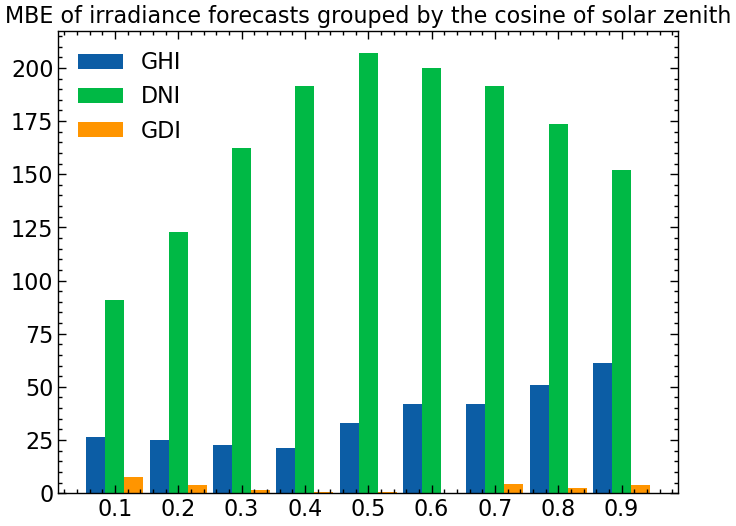

In [167]:
plt.figure()
x_axis = np.arange(len(mean_df.index))
plt.bar(x_axis-0.3, abs(mean_df["downward_surface_SW_flux_mean"]), 0.3, label = "GHI")
plt.bar(x_axis, abs(mean_df["direct_surface_SW_flux_mean"]), 0.3, label = "DNI")
plt.bar(x_axis+0.3, abs(mean_df["diffuse_surface_SW_flux_mean"]), 0.3, label = "GDI")
plt.title('MBE of irradiance forecasts grouped by the cosine of solar zenith')
plt.xticks(ticks = range(len(mean_df.index)-1), labels = [x/10 for x in range(1, 10)])

plt.legend()
plt.show()

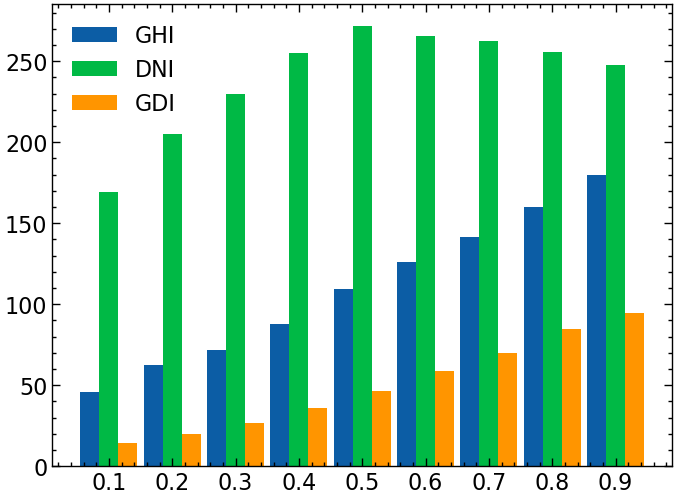

In [168]:
plt.figure()
x_axis = np.arange(len(rmse_df.index))
plt.bar(x_axis-0.3, abs(rmse_df["downward_surface_SW_flux_rmse"]), 0.3, label = "GHI")
plt.bar(x_axis, abs(rmse_df["direct_surface_SW_flux_rmse"]), 0.3, label = "DNI")
plt.bar(x_axis+0.3, abs(rmse_df["diffuse_surface_SW_flux_rmse"]), 0.3, label = "GDI")
plt.xticks(ticks = range(len(mean_df.index)-1), labels = [x/10 for x in range(1, 10)])


plt.legend()
plt.show()

In [169]:
daytime = daytime[daytime['is_day']]
plt.scatter(daytime['downward_surface_SW_flux'], daytime['P'], s=2)

NameError: name 'daytime' is not defined